#Task 1: Time Series Analysis
This task focuses on analyzing data points collected over time to forecast future trends. We will use a synthetic dataset that mimics typical sales data with a clear trend and seasonality.

--- Original Time Series ---


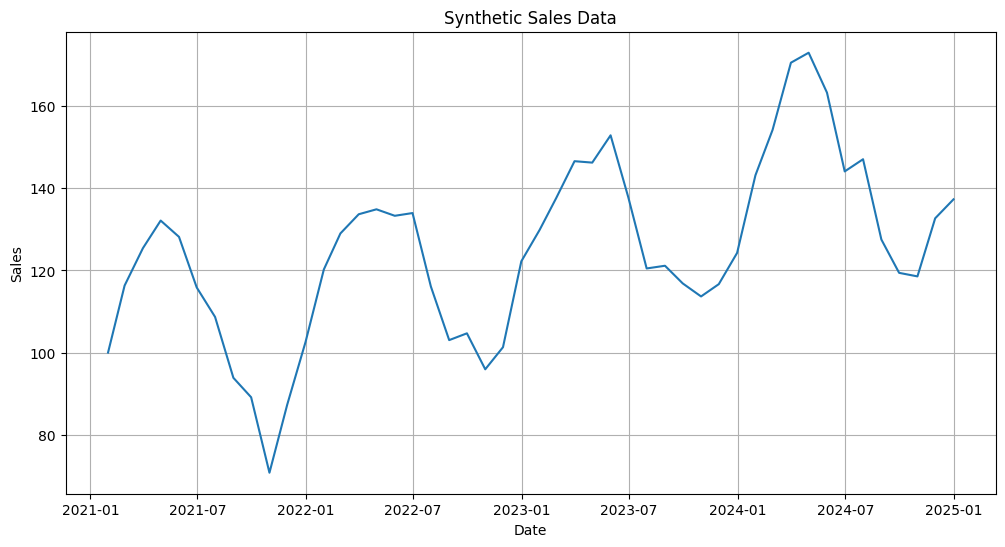


--- Time Series Decomposition ---


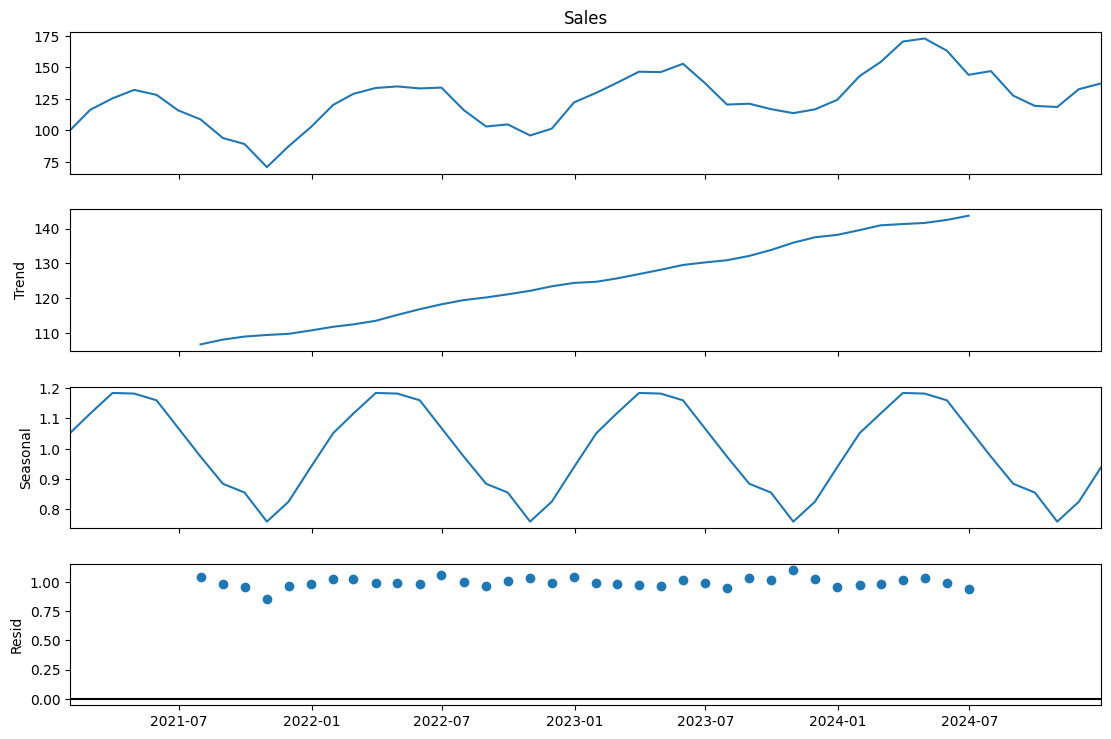


--- Smoothing Techniques ---


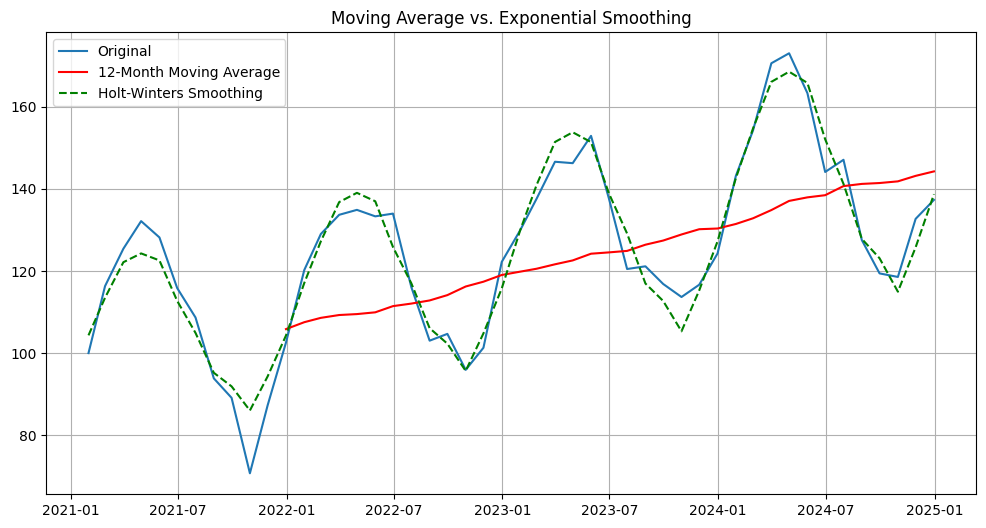


--- SARIMA Model Summary ---
                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   36
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -76.115
Date:                            Sun, 05 Oct 2025   AIC                            162.230
Time:                                    16:17:03   BIC                            167.908
Sample:                                01-31-2021   HQIC                           163.658
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1527      0.405      0.377      0.706      -0.642       0.947
ma.L1

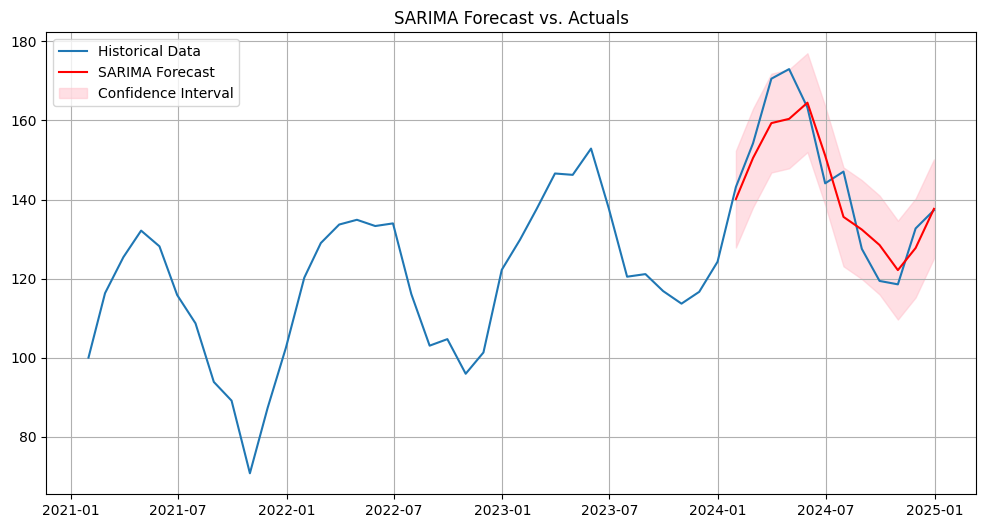

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings("ignore")

# --- 1. Generate and Plot a Sample Time Series ---
# Create a synthetic dataset with trend and seasonality
date_rng = pd.date_range(start='2021-01-01', end='2024-12-31', freq='M')
data = np.linspace(100, 150, len(date_rng)) + \
       np.sin(np.arange(len(date_rng)) * (2 * np.pi / 12)) * 25 + \
       np.random.normal(0, 5, len(date_rng))
ts = pd.Series(data, index=date_rng)
ts.rename("Sales", inplace=True)

print("--- Original Time Series ---")
plt.figure(figsize=(12, 6))
plt.plot(ts)
plt.title('Synthetic Sales Data')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

# --- 2. Decompose the Time Series ---
# Using a multiplicative model because the seasonality appears to grow with the trend
decomposition = seasonal_decompose(ts, model='multiplicative')

print("\n--- Time Series Decomposition ---")
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

# --- 3. Moving Average and Exponential Smoothing ---
# Moving Average
ts_ma = ts.rolling(window=12).mean()

# Holt-Winters Exponential Smoothing
# 'add' for additive trend, 'mul' for multiplicative seasonality
model_hw = ExponentialSmoothing(ts, trend='add', seasonal='mul', seasonal_periods=12).fit()
ts_hw = model_hw.fittedvalues

print("\n--- Smoothing Techniques ---")
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Original')
plt.plot(ts_ma, label='12-Month Moving Average', color='red')
plt.plot(ts_hw, label='Holt-Winters Smoothing', color='green', linestyle='--')
plt.title('Moving Average vs. Exponential Smoothing')
plt.legend()
plt.grid(True)
plt.show()

# --- 4. Build and Evaluate a SARIMA Model ---
# Split data into training and testing sets
train_data = ts[:-12]
test_data = ts[-12:]

# Define and fit the SARIMA model
# These parameters (p,d,q)(P,D,Q,m) are often found using ACF/PACF plots or grid search.
# We'll use common values for this kind of data. m=12 for monthly seasonality.
sarima_model = SARIMAX(train_data,
                       order=(1, 1, 1),
                       seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit(disp=False)
print("\n--- SARIMA Model Summary ---")
print(sarima_fit.summary())

# --- 5. Forecast and Visualize ---
# Generate forecasts for the test period
forecast = sarima_fit.get_forecast(steps=len(test_data))
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int() # Confidence intervals

# Evaluate the model
rmse = np.sqrt(mean_squared_error(test_data, forecast_mean))
print(f"\nSARIMA Model RMSE: {rmse:.2f}")

# Visualize the forecast
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Historical Data')
plt.plot(forecast_mean, label='SARIMA Forecast', color='red')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.5, label='Confidence Interval')
plt.title('SARIMA Forecast vs. Actuals')
plt.legend()
plt.grid(True)
plt.show()

#Task 2: Natural Language Processing (NLP) - Text Classification
This task involves training a model to classify text. A classic example is a spam filter, which classifies emails as "spam" or "not spam" (ham).

In [11]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# --- Download NLTK data (only need to do this once) ---
nltk.download('punkt')
nltk.download('punkt_tab') # Added download for punkt_tab
nltk.download('stopwords')
nltk.download('wordnet')

# --- 1. Create a Sample Dataset ---
data = {
    'text': [
        'Congratulations! You have won a free ticket to the Bahamas.',
        'Hi Mom, I will be home for dinner tonight.',
        'URGENT: Your account has been compromised. Click here to secure it.',
        'Can we reschedule our meeting for tomorrow?',
        'Claim your exclusive free prize now!',
        'The project deadline is approaching fast.',
        'Get a free iPhone 15 by clicking this link.',
        'Thanks for your email. I will look into it.'
    ],
    'label': ['spam', 'ham', 'spam', 'ham', 'spam', 'ham', 'spam', 'ham']
}
df = pd.DataFrame(data)
print("--- Original Dataset ---")
print(df)

# --- 2. Preprocess Text Data ---
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove stopwords and lemmatize
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(lemmatized_tokens)

df['processed_text'] = df['text'].apply(preprocess_text)
print("\n--- Preprocessed Dataset ---")
print(df[['processed_text', 'label']])

# --- 3. Convert Text to Numerical Representation (TF-IDF) ---
X = df['processed_text']
y = df['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000) # Use top 1000 features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"\nShape of TF-IDF training matrix: {X_train_tfidf.shape}")

# --- 4. Train a Classification Model (Naive Bayes) ---
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)
print("\n--- Naive Bayes Model Trained ---")

# --- 5. Evaluate the Model ---
y_pred = nb_classifier.predict(X_test_tfidf)

print("\n--- Model Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# --- Example Prediction ---
new_text = "Claim your free vacation package now"
processed_new_text = preprocess_text(new_text)
new_text_tfidf = tfidf_vectorizer.transform([processed_new_text])
prediction = nb_classifier.predict(new_text_tfidf)
print(f"\nPrediction for '{new_text}': {prediction[0]}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


--- Original Dataset ---
                                                text label
0  Congratulations! You have won a free ticket to...  spam
1         Hi Mom, I will be home for dinner tonight.   ham
2  URGENT: Your account has been compromised. Cli...  spam
3        Can we reschedule our meeting for tomorrow?   ham
4               Claim your exclusive free prize now!  spam
5          The project deadline is approaching fast.   ham
6        Get a free iPhone 15 by clicking this link.  spam
7        Thanks for your email. I will look into it.   ham

--- Preprocessed Dataset ---
                            processed_text label
0       congratulation free ticket bahamas  spam
1               hi mom home dinner tonight   ham
2  urgent account compromised click secure  spam
3              reschedule meeting tomorrow   ham
4               claim exclusive free prize  spam
5        project deadline approaching fast   ham
6            get free iphone clicking link  spam
7                     

#Task 3: Neural Networks with TensorFlow/Keras
This task involves building a simple feed-forward neural network to classify images from the famous MNIST dataset, which contains handwritten digits (0-9).

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Original shape of training data: (60000, 28, 28)
Original label: 5
One-hot encoded label: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]

--- Model Architecture ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)


--- Training the Model ---
Epoch 1/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8690 - loss: 0.4635 - val_accuracy: 0.9658 - val_loss: 0.1286
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9608 - loss: 0.1336 - val_accuracy: 0.9735 - val_loss: 0.0962
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9739 - loss: 0.0880 - val_accuracy: 0.9702 - val_loss: 0.0984
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9815 - loss: 0.0614 - val_accuracy: 0.9778 - val_loss: 0.0793
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9861 - loss: 0.0458 - val_accuracy: 0.9785 - val_loss: 0.0771
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9891 - loss: 0.0354 - val_accuracy: 0.9808 - val_loss: 0.0723
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9906 - loss: 0.0297 - val_accuracy: 0.9793 - val_loss: 0.0773
Epoch 8/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accu

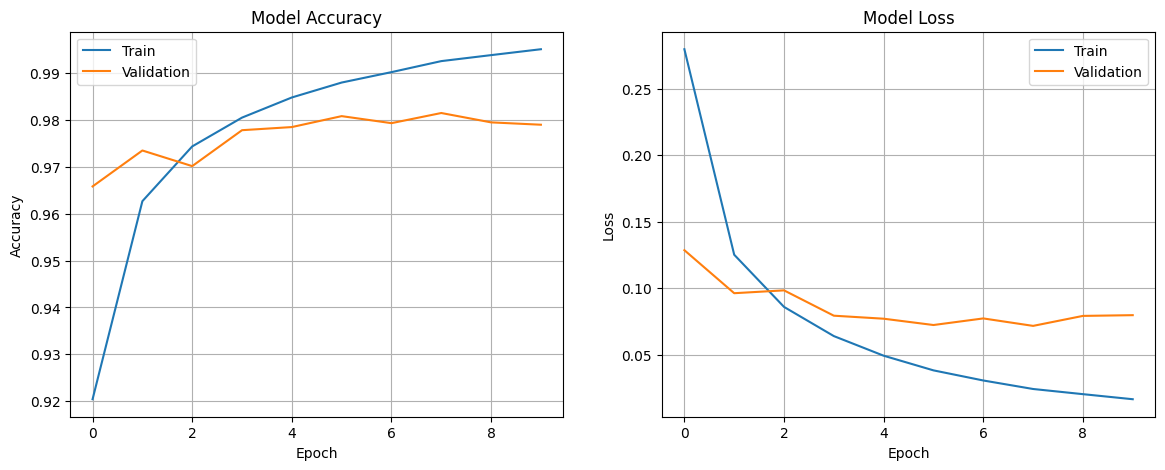


--- Hyperparameter Tuning Discussion ---
To improve performance, you can tune hyperparameters like:
- Learning Rate: Control how much to change the model in response to the estimated error.
- Batch Size: Affects the stability and speed of training.
- Number of Epochs: Too few can lead to underfitting, too many to overfitting.
- Network Architecture: Number of layers and neurons per layer.


In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Load and Preprocess the Dataset (MNIST) ---
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print(f"Original shape of training data: {x_train.shape}")

# Normalize pixel values to be between 0 and 1
x_train = x_train / 255.0
x_test = x_test / 255.0

# One-hot encode the labels
# e.g., 5 -> [0,0,0,0,0,1,0,0,0,0]
y_train_one_hot = keras.utils.to_categorical(y_train, num_classes=10)
y_test_one_hot = keras.utils.to_categorical(y_test, num_classes=10)

print(f"Original label: {y_train[0]}")
print(f"One-hot encoded label: {y_train_one_hot[0]}")

# --- 2. Design the Neural Network Architecture ---
model = Sequential([
    # Flatten the 28x28 images into a 784-dimensional vector
    Flatten(input_shape=(28, 28)),
    # Hidden layer with 128 neurons and ReLU activation function
    Dense(128, activation='relu'),
    # Output layer with 10 neurons (one for each digit) and softmax activation
    Dense(10, activation='softmax')
])

# --- 3. Compile the Model ---
# Adam optimizer is a good default choice.
# For multi-class classification, categorical_crossentropy is the standard loss function.
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("\n--- Model Architecture ---")
model.summary()

# --- 4. Train the Model ---
print("\n--- Training the Model ---")
# An epoch is one complete pass through the entire training dataset.
# Batch size is the number of samples processed before the model is updated.
history = model.fit(x_train, y_train_one_hot,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.1) # Use 10% of training data for validation

# --- 5. Evaluate the Model ---
test_loss, test_acc = model.evaluate(x_test, y_test_one_hot, verbose=2)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# --- 6. Visualize Training History (Accuracy and Loss Curves) ---
plt.figure(figsize=(14, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)

plt.show()

# --- 7. Hyperparameter Tuning (Conceptual Example) ---
print("\n--- Hyperparameter Tuning Discussion ---")
print("To improve performance, you can tune hyperparameters like:")
print("- Learning Rate: Control how much to change the model in response to the estimated error.")
print("- Batch Size: Affects the stability and speed of training.")
print("- Number of Epochs: Too few can lead to underfitting, too many to overfitting.")
print("- Network Architecture: Number of layers and neurons per layer.")

# Example of using a custom learning rate
# from tensorflow.keras.optimizers import Adam
# custom_optimizer = Adam(learning_rate=0.0005)
# model.compile(optimizer=custom_optimizer, ...)